In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# Get current working directory
cwd = pathlib.Path.cwd()

In [3]:
# Load data from cwd
ds1, ds2, ds3 = tfds.load('patch_camelyon', split=['train[:30%]', 'test[:7%]', 'validation[:7%]'], 
                                data_dir=cwd, 
                                download=False, 
                                shuffle_files=True)

In [4]:
# Hyperparameters:
image_shape = [24,24]
file_name = 'resize_24_p10'

In [5]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.resize(image,image_shape)
    image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image/ 255.0, label

In [6]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

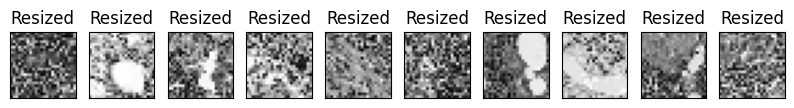

In [7]:
for images, _ in train_dataset.take(1):
    input_shape = images[0].shape

# Define how many images you want to display
n = 10  # for example, display 10 images

plt.figure(figsize=(n, 2))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("Resized")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig(f"{file_name}_simple.png")
plt.show()
plt.close()

In [8]:
# Create a new CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_model=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # early stopping

# Print the summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 295,426
Trainable params: 295,426
Non-trainable params: 0
__________________________________________________

In [9]:
# Train the model
history = cnn_model.fit(train_dataset, 
              validation_data=validation_dataset,
              callbacks=[callback_model],
              epochs=55)

Epoch 1/55
2458/2458 [==============================] - 22s 9ms/step - loss: 0.5088 - accuracy: 0.7534 - val_loss: 0.4620 - val_accuracy: 0.7799
Epoch 2/55
2458/2458 [==============================] - 22s 9ms/step - loss: 0.4716 - accuracy: 0.7815 - val_loss: 0.4578 - val_accuracy: 0.7908
Epoch 3/55
2458/2458 [==============================] - 21s 9ms/step - loss: 0.4645 - accuracy: 0.7860 - val_loss: 0.4771 - val_accuracy: 0.7690
Epoch 4/55
2458/2458 [==============================] - 21s 9ms/step - loss: 0.4574 - accuracy: 0.7914 - val_loss: 0.4463 - val_accuracy: 0.7895
Epoch 5/55
2458/2458 [==============================] - 21s 9ms/step - loss: 0.4515 - accuracy: 0.7921 - val_loss: 0.4679 - val_accuracy: 0.7825
Epoch 6/55
2458/2458 [==============================] - 21s 9ms/step - loss: 0.4457 - accuracy: 0.7966 - val_loss: 0.4557 - val_accuracy: 0.7868
Epoch 7/55
2458/2458 [==============================] - 21s 9ms/step - loss: 0.4403 - accuracy: 0.8004 - val_loss: 0.4432 - val_ac

In [10]:
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_df.to_csv(f"simple_{file_name}_history.csv")

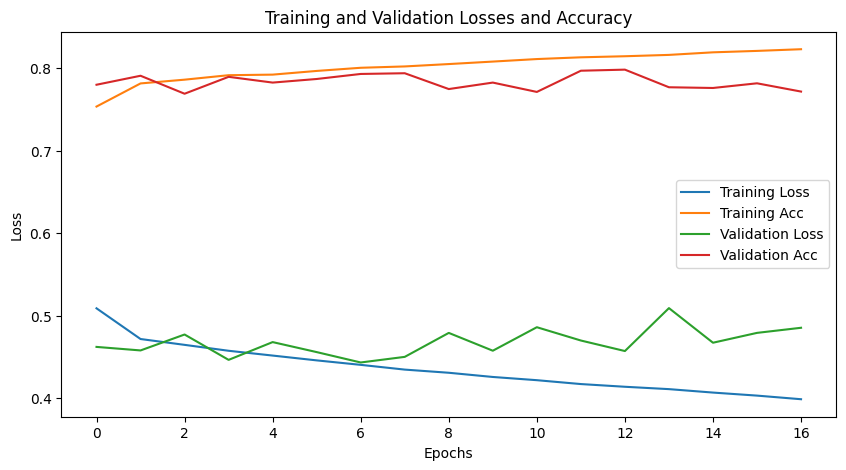

In [18]:
# Plotting the training and validation loss
# Extract training and validation losses
train_losses = history.history['loss']
train_acc = history.history['accuracy']
val_losses = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_acc, label = 'Training Acc')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_acc, label = 'Validation Acc')
plt.title('Training and Validation Losses and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'training_validation_loss_plot_simple_{file_name}.png')
plt.show()

In [12]:
predictions = cnn_model.predict(test_dataset)

predictions = np.argmax(predictions, axis=1)

predictions_pd = pd.DataFrame({
    'Id': list(range(len(predictions))),
    'Predicted': predictions.reshape(-1,),
})

predictions_pd.to_csv(f'final_predictions_simple_{file_name}.csv', index=False)

72/72 [==============================] - 0s 2ms/step


In [13]:
# Assuming the encoded_test_dataset is already batched and prefetched
true_labels = []
for images, labels in test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

# If true_labels is one-hot encoded, convert it to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate predictions
predictions = cnn_model.predict(test_dataset)

# If predictions are probabilities, use argmax to get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)

# Open the file in write mode ('w') and write the string to it
with open(f"accuracy_simple_{file_name}.csv", 'w') as file:
    file.write(my_string)

72/72 [==============================] - 0s 4ms/step
Accuracy: 77.81%


# Adding 3rd channel


In [14]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.resize(image, [48, 48])
    # Removed the conversion to grayscale
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image/ 255.0, label

train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)


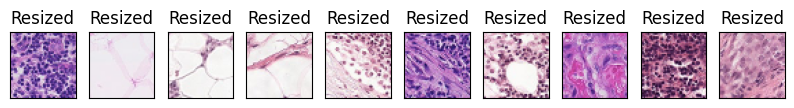

In [15]:
for images, _ in train_dataset.take(1):
    input_shape = images[0].shape

# Define how many images you want to display
n = 10  # for example, display 10 images

plt.figure(figsize=(n, 2))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("Resized")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig(f"resized_images_{file_name}_color.png")
plt.show()
plt.close()

In [16]:


# Adjust input shape for color images
#input_shape = (48, 48, 3)  # 3 channels for RGB

# Create a new CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
callback_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Print the summary of the model
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1179712   
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,180,738
Trainable params: 1,180,738
Non-trainable params: 0
____________________________________________

In [19]:
# Train the model
history = cnn_model.fit(train_dataset, 
              validation_data=validation_dataset,
              callbacks=[callback_model],
              epochs=55)

# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_df.to_csv(f"{file_name}_color_history.csv")

Epoch 1/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1982 - accuracy: 0.9223 - val_loss: 0.8033 - val_accuracy: 0.7546
Epoch 2/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1743 - accuracy: 0.9323 - val_loss: 0.8805 - val_accuracy: 0.7585
Epoch 3/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1594 - accuracy: 0.9394 - val_loss: 0.9134 - val_accuracy: 0.7711
Epoch 4/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1429 - accuracy: 0.9463 - val_loss: 0.9353 - val_accuracy: 0.7568
Epoch 5/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1263 - accuracy: 0.9535 - val_loss: 1.1253 - val_accuracy: 0.7611
Epoch 6/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 1.4383 - val_accuracy: 0.7219
Epoch 7/55
2458/2458 [==============================] - 18s 7ms/step - loss: 0.1100 - accuracy: 0.9603 - val_loss: 1.2748 - val_ac

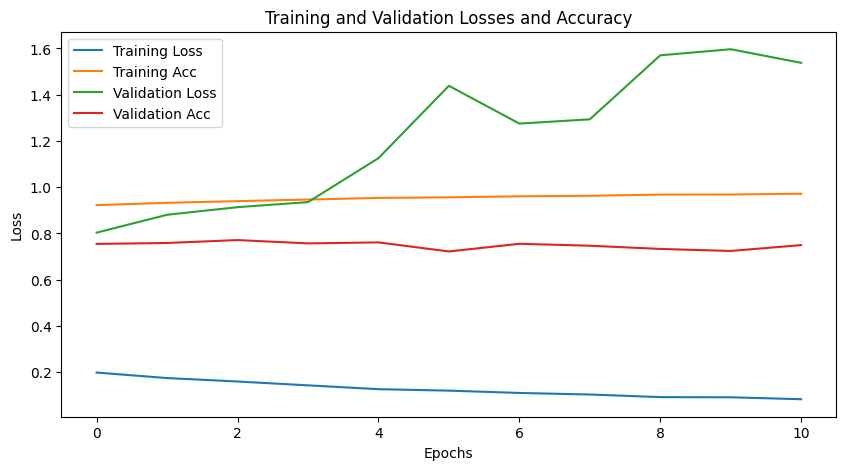

In [20]:
# Plotting the training and validation loss
# Extract training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_acc, label = 'Training Acc')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_acc, label = 'Validation Acc')
plt.title('Training and Validation Losses and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'training_validation_loss_plot_{file_name}_color.png')
plt.show()


In [21]:
predictions = cnn_model.predict(test_dataset)

predictions = np.argmax(predictions, axis=1)

predictions_pd = pd.DataFrame({
    'Id': list(range(len(predictions))),
    'Predicted': predictions.reshape(-1,),
})

predictions_pd.to_csv(f'final_predictions_{file_name}_color.csv', index=False)

72/72 [==============================] - 0s 4ms/step


In [22]:
# Assuming the encoded_test_dataset is already batched and prefetched
true_labels = []
for images, labels in test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

# If true_labels is one-hot encoded, convert it to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate predictions
predictions = cnn_model.predict(test_dataset)

# If predictions are probabilities, use argmax to get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)

# Open the file in write mode ('w') and write the string to it
with open(f"accuracy_{file_name}_color.csv", 'w') as file:
    file.write(my_string)

72/72 [==============================] - 0s 3ms/step
Accuracy: 73.54%
